# 4차 테스트
* 학습 데이터 : eda_data.csv(약 16000개)
* 채점 데이터 : test_data.csv(약 1700개)
* fasttext.vec 파일 드라이브에서 마운트

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import os
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

In [ ]:
train = pd.read_csv('eda_data.csv')
train.head()

,html,label
0,Best Financial Service - #1 shop to ear...,1
1,"bitcoin, bitcoin generator, free bitcoin ...",1
2,Underground Market - Prepaid & Cloned Cards...,1
3,Stolen Cards | Plastic Sharks ...,1
4,Best Amazon Gift Card ...,0


In [ ]:
train['label'] = train['label'].apply(lambda x: int(x))   # 원활한 모델학습을 위해 int형으로 유형변경
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14964 entries, 0 to 14963
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   html    14964 non-null  object
 1   label   14964 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 233.9+ KB


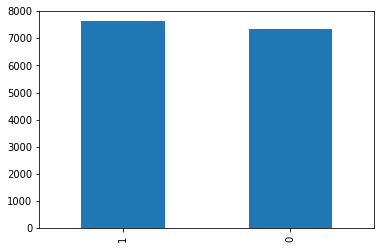

In [ ]:
# 데이터 분포 확인
train['label'].value_counts().plot(kind='bar')

In [ ]:
# 데이터 개수 확인
input = train['html']
target = train['label']
print('html개수 확인 : ',len(input))
print('label개수 확인 : ',len(target))

html개수 확인 :  14964
label개수 확인 :  14964


## 영어가 아닌 기호 전처리
* 영어가 아닌 특수문자를 내버려두면 모델이 제대로 학습하지 못함
* 하지만, 모든 특수문자를 제거하면 의미있는 값들도 제거될 수 있음
  * 토의 결과 통화기호(\\,$)와 .(마침표)는 살려두기로 결정

In [ ]:
# 영어 아닌 특수문자(영어 외 언어 및 특수기호)을 전부 처리하는 코드 작성
'''
nltk.download('words')
words = set(nltk.corpus.words.words())
processed_html = []
for num in range(2494):
  a = input[num]
  if '$' in a :                               
    sent = re.sub('[^a-zA-z0-9$]',' ',a)      
    edit = " ".join(w for w in nltk.wordpunct_tokenize(sent) \
            if w.lower() in words or not w.isalpha())
    processed_html.append(edit)
  else : 
    sent = re.sub('[^a-zA-z0-9]',' ',a)
    edit_2 = " ".join(w for w in nltk.wordpunct_tokenize(sent) \
            if w.lower() in words or not w.isalpha())
    processed_html.append(edit_2)
len(processed_html)
'''
# 위 코드(이전 버전)는 31000개 정도
# 아래 코드는 단어 집합이 약 76000개 나옴
# 아래 코드로 버전업

nltk.download('words')
words = set(nltk.corpus.words.words())
processed_html = []                   # 빈 리스트 생성
for num in range(len(input)):
  a = input[num]                      # 각 html에 대해서
  sent = re.sub(r'(\dBTC)',' BTC ',a)
  sent_2 = re.sub('[^a-zA-Z0-9\$.]+', ' ', sent)     # 전처리 수행(영어/숫자/원/달러/마침표 제외 전부 제거)
  #edit = " ".join(w for w in nltk.wordpunct_tokenize(sent) \
  #        if w.lower() in words or not w.isalpha())                     ---> nltk모듈의 corpus 사전 내에 없는 단어를 제거하는 로직인데 은어들이 전부 제거되어 주석처리 했습니다 
  processed_html.append(sent_2)
len(processed_html)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


14964

In [ ]:
processed_html[96]

' AUTOMATED PAYPAL AND CREDIT CARD MARKET AUTOMATED PAYPAL AND CREDIT CARD MARKET. AUTOMATED PAYPAL AND CREDIT CARD MARKET BE AWARE OF SCAMMERS WHO COPY OUR SITE This is our one and ONLY site http 4dxawxyzkmo262eefiymmqsw4zl5gg7wbp7wney3mqx6h6i3ux2qaiad.onion Please bookmark us. CLICK HERE FOR FEEDBACK PAGE FEEDBACK SYSTEM. We offer fresh new accounts every 2 days different balances and prices all 100 verified accounts free clean socks5 for every account in the same country as the holder all accounts have balance account replacing if amount is differ than we agreed complete step by step walkthrough guide Easy cash out cashing out WORLDWIDE in 12h or faster Last update Oct 20 2021 Verified balance PayPal accounts Verified balance PayPal accounts All with 100 verified balance cashout guide and socks5. Worldwide PayPal acc tutorial socks5 $522 PP ACC 50$ 0.0007822 BTC $1076 PP ACC 90$ 0.0014080 BTC $1531 PP ACC 150$ 0.0023466 BTC $2257 PP ACC 210$ 0.0032853 BTC $3364 PP ACC 300$ 0.0046933

In [ ]:
# 불용어 리스트
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('english'))
len(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

179

In [ ]:
# 불용어 단어 추가시
stop_words = set(stopwords.words('english'))
new_stop_words = []  # 추가할 불용어 리스트 안에 작성
stop_words.update(new_stop_words)
print('불용어 단어 개수 : ',len(stop_words))

불용어 단어 개수 :  179


In [ ]:
# 불용어 제거 로직
from tensorflow.keras.preprocessing.text import text_to_word_sequence
result = []   # 빈 리스트
for num in range(len(input)):
  word_tokens = text_to_word_sequence(processed_html[num],filters='!"#%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')   # processed_html 모든 문장을 단어별로 쪼개줌
                                                                                                          # filters옵션: 원화/달러/마침표 제외한 특수문자 제거(보험용)
  each_list = []            # 각 html별 list
  for w in word_tokens:
    if w not in stop_words:    # 불용어 체크한 뒤 불용어 아닌 단어들만 each_list에 포함
      each_list.append(w)
  result.append(each_list)     # 각각의 each_list를 result안에 집어넣음
print(result)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 수행 결과, result 안 내용

result = [[like, korea Japan] , [bitcoin, up, down] , .....]


In [ ]:
# 임베딩 작업 수행
tokenizer = Tokenizer(filters='!"#%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')   # filters옵션(보험용)
tokenizer.fit_on_texts(result)
sequences = tokenizer.texts_to_sequences(result)   # 각 단어를 숫자로 변환하는 모듈
print(sequences[:5])

[[43, 580, 57, 10, 76, 1160, 154, 38, 11, 3628, 35, 136, 97, 1, 20, 1, 153, 6, 9, 7, 89, 72, 27, 522, 840, 107, 213, 123, 27, 366, 143, 204, 43, 125, 54, 99, 161, 962, 446, 43, 580, 99, 29, 97, 20, 1, 11, 89, 146, 6, 9, 7, 202, 148, 2717, 125, 6728, 202, 615, 1538, 2628, 99, 1791, 1267, 28, 1275, 2677, 46, 840, 926, 666, 43, 580, 99, 106, 43, 243, 148, 13, 415, 685, 6409, 2821, 22, 115, 748, 6091, 278, 107, 2, 2172, 95, 288, 120, 231, 1734, 880, 945, 305, 45, 184, 43, 177, 215, 190, 101, 1473, 88, 362, 2341, 187, 88, 2401, 123, 2069, 14083, 231, 152, 100, 146, 123, 934, 633, 111, 202, 1, 269, 2402, 1127, 28, 129, 588, 1, 4031, 535, 2777, 4134, 244, 895, 1134, 120, 193, 335, 48, 501, 29, 1, 35, 1, 1457, 132, 24, 368, 1290, 2256, 1700, 1, 1907, 1, 991, 358, 3162, 97, 1, 602, 4377, 616, 2, 983, 11, 29, 296, 2, 1586, 5374, 28, 348, 186, 514, 1319, 4248, 1844, 4032, 100, 101, 493, 56, 275, 117, 91, 274, 43, 186, 31, 348, 129, 514, 10, 2, 377, 77, 957, 88, 6410, 23, 3222, 100, 101, 493, 56, 

In [ ]:
word_to_index = tokenizer.word_index    
word_to_index
# tokenizer.word_index
# 전체 데이터를 통틀어 등장한 단어의 빈도수로 정렬
# 숫자가 적을수록 데이터 내 많이 등장한 것

{'cards': 1,
 'card': 2,
 '$': 3,
 'buy': 4,
 'bitcoin': 5,
 'paypal': 6,
 'union': 7,
 'usd': 8,
 'western': 9,
 '1': 10,
 'money': 11,
 'get': 12,
 'us': 13,
 'x': 14,
 'http': 15,
 'payment': 16,
 'transfer': 17,
 '2': 18,
 '2020': 19,
 'gift': 20,
 'tor': 21,
 '5': 22,
 'order': 23,
 'account': 24,
 'de': 25,
 'credit': 26,
 'btc': 27,
 'use': 28,
 'prepaid': 29,
 '10': 30,
 'online': 31,
 'send': 32,
 '2000': 33,
 '.': 34,
 'visa': 35,
 '155': 36,
 '3': 37,
 'free': 38,
 'contact': 39,
 'want': 40,
 'r': 41,
 'add': 42,
 'best': 43,
 'email': 44,
 'shipping': 45,
 'new': 46,
 'eur': 47,
 'cash': 48,
 '12': 49,
 '0': 50,
 'iphone': 51,
 'accounts': 52,
 '01': 53,
 'web': 54,
 'yes': 55,
 '4': 56,
 'service': 57,
 'e': 58,
 'transaction': 59,
 'debit': 60,
 'price': 61,
 'name': 62,
 'cart': 63,
 'number': 64,
 '...': 65,
 'united': 66,
 '2021': 67,
 'time': 68,
 'n': 69,
 'moneygram': 70,
 '20': 71,
 'pay': 72,
 'receive': 73,
 'make': 74,
 'hours': 75,
 'shop': 76,
 'balance': 77,

In [ ]:
# 단어확인용 파일 저장
train_word = pd.DataFrame(list(word_to_index.items()),columns = ['word','rank'])
train_word.to_csv('word.csv',index=False)

In [ ]:
vocab_size = len(word_to_index) + 1
print('학습할 단어집합 크기: ',vocab_size)

학습할 단어집합 크기:  89364


In [ ]:
# train_test_split
# 이 과정은 생략가능
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(sequences,target,test_size=0.2,random_state=42,
                                                 stratify=target)

html 최대 길이 :  6485
html 평균 길이 :  406.8757016840417


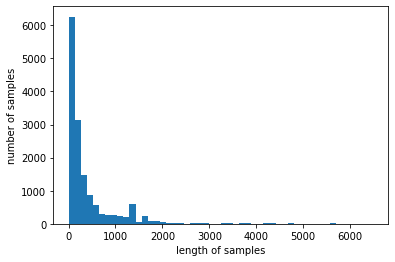

In [ ]:
# html 길이 통계
print('html 최대 길이 : ',max(len(l) for l in sequences))
print('html 평균 길이 : ',(sum(map(len,sequences)))/len(sequences))
plt.hist([len(s) for s in sequences],bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# html을 max_len 길이까지만 분석 --> 나머지 데이터는 전부 0으로 변환(해석에 영향X)
max_len = 2000  # 초기설정값 4000  --> 학습성능저하 이슈로 2000으로 낮춤
train_seq = pad_sequences(X_train,maxlen=max_len)  # 각 html을 max_len 길이에 맞게 잘라주는 모듈
test_seq = pad_sequences(X_test,maxlen=max_len)  
# test_seq는 생략가능
# train_seq의 첫 옵션을 반드시 X_train --> sequences 로 바꿔야 합니다

## 외부 단어사전 불러오기(FastText)
* 데이터셋의 9만개 단어를 다 학습했을때 모델 성능이 저조해
* 검증된 외부 단어사전의 단어들로만 학습/예측하면 어떨지 테스트

In [ ]:
# Drive 폴더와 연결
# 연결할때마다 매번 url로 들어가 인증코드 받는 절차 필요
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# FastText단어 불러오기
def load_embedding(path):
    embeddings = {}
    with open(path) as f:
        for line in f:
            values = line.rstrip().split()   # rstrip() --> 맨 오른쪽 다른 크기의 공백 전부 잘라줌 
                                             # split()  --> 공백기준으로 임베딩(float) 구분
            word = values[0]                # word에 영단어 할당
            vector = np.asarray(values[1:],dtype=np.float32) # vector에 임베딩(float) 할당
                                                             # np.asarray() --> 데이터 형태를 array로 --> RAM 터지는 것 방지
                                                             # dtype=np.float32 --> vec파일의 float은 64비트 --> 32비트 float으로 바꿔서 메모리 소모량 감소
            embeddings[word] = vector         # embedding의 word의 value --> vector(float32)
    return embeddings

embeddings = load_embedding('/content/gdrive/MyDrive/fasttext.vec')


In [ ]:
# 우리 데이터셋 단어들과 FastText 단어들 중 일차하는 것만 살리는 함수

def filter_embedding(embeddings,word_to_index,vocab_size,dim):
    embedding_matrix = np.zeros([vocab_size,dim])    # train 데이터셋 단어크기에 맞는 행렬 생성
    for word,i in word_to_index.items():                # word_to_index의 단어 및 랭크 추출
        vector = embeddings.get(word)                # get 함수 --> 맞는 단어가 없을시 None 리턴
        if vector is not None:                       # Vector값이 NaN이 아닐때
            embedding_matrix[i] = vector             # embedding_matrix에 fast_text의 임베딩(float)할당
    return embedding_matrix

embedding_matrix = filter_embedding(embeddings,word_to_index,vocab_size,300)   # 리턴값 embedding_matrix가 모델 학습에 사용될 최종 데이터
print(embedding_matrix[1])

[ 0.36860001 -0.0538     -0.0852     -0.26899999  0.52209997  0.0389
 -0.0069     -0.0198      0.1737      0.0295      0.13160001  0.412
  0.0175     -0.0119     -0.1885     -0.0592     -0.0977     -0.0684
  0.0668     -0.4693      0.537      -0.12729999  0.14040001  0.1992
 -0.0713     -0.0872      0.3475      0.1417     -0.28510001 -0.0358
 -0.2489      0.32690001 -0.0194     -0.1964     -0.29170001  0.31650001
  0.0023     -0.1155     -0.0999      0.3829     -0.39410001 -0.1964
  0.1235      0.1229      0.063      -0.2613      0.1726      0.1859
 -0.1085      0.0053      0.1104      0.0429      0.25139999 -0.212
  0.0226      0.014       0.0851     -0.0363     -0.28960001 -0.1902
 -0.1035     -0.42719999 -0.0166     -0.2175      0.3299     -0.0042
  0.17739999  0.045       0.30930001  0.1691      0.0827     -0.48570001
 -0.3594      0.1772      0.2638     -0.2243     -0.5381     -0.1974
  0.0792     -0.26629999  0.2378     -0.0058     -0.2133      0.13349999
  0.3506     -0.1249    

In [ ]:
print('FastText로 걸러진 데이터셋의 단어 개수 : ',len(set(word_to_index) - set(embeddings)))
removed_words = set(word_to_index) - set(embeddings)
train_2 = pd.DataFrame(removed_words,columns=['word'])
train_2.to_csv('removed_words.csv',index=False)

FastText로 걸러진 데이터셋의 단어 개수 :  45777


# Embedding (RNN)모델 사용

In [ ]:
# TPU 사용관련(보류)
'''
def create_rnn_model():
  model = Sequential()
  model.add(Embedding(vocab_size,128,input_length=4000))
  model.add(SimpleRNN(64))
  model.add(Dense(1,activation='sigmoid'))
  return model
'''

In [ ]:
# TPU 사용관련(보류)
'''
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)

tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)
with strategy.scope():
  model = create_rnn_model()
  cp = callbacks.ModelCheckpoint('best-embedding-model2.h5')
  es = callbacks.EarlyStopping(patience=3,restore_best_weights=True,verbose=1)
  rl = callbacks.ReduceLROnPlateau(patience=2)
  opt = optimizers.Adam(learning_rate=0.01)
  model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])

  history_2 = model.fit(train_seq,y_train,epochs=10,validation_split=0.2,batch_size=32,callbacks=[cp,es,rl])
  '''

In [ ]:
# 이전버전 모델
'''
model = Sequential()
model.add(Embedding(vocab_size,128,input_length=2000))   # input_length 줄이기     # Embedding으로만 학습 Embedding--> Flatten
model.add(SimpleRNN(64,return_sequences=True))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
'''

# 모델 업그레이드

model = Sequential()
model.add(Embedding(vocab_size,300,input_length=2000,weights=[embedding_matrix],
                    trainable=False))
model.add(SpatialDropout1D(0.25))
model.add(SimpleRNN(128,return_sequences=True))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 2000, 300)         26809200  
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 2000, 300)        0         
 lDropout1D)                                                     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 2000, 128)         54912     
                                                                 
 flatten_2 (Flatten)         (None, 256000)            0         
                                                                 
 dense_4 (Dense)             (None, 64)                16384064  
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                      

In [ ]:
cp = callbacks.ModelCheckpoint('best-embedding-model2.h5')
es = callbacks.EarlyStopping(patience=3,restore_best_weights=True,verbose=1)
rl = callbacks.ReduceLROnPlateau(patience=2)
opt = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])
history_2 = model.fit(train_seq,y_train,epochs=5,validation_split=0.2,batch_size=32,callbacks=[cp,es,rl])  

Epoch 1/5
300/300 [==============================] - 614s 2s/step - loss: 34.9216 - acc: 0.5060 - val_loss: 10.6928 - val_acc: 0.5203 - lr: 0.0100
Epoch 2/5
300/300 [==============================] - 621s 2s/step - loss: 4.0262 - acc: 0.5077 - val_loss: 0.7183 - val_acc: 0.5194 - lr: 0.0100
Epoch 3/5
300/300 [==============================] - 627s 2s/step - loss: 2.8686 - acc: 0.5085 - val_loss: 2.0374 - val_acc: 0.5248 - lr: 0.0100
Epoch 4/5
300/300 [==============================] - 619s 2s/step - loss: 2.2209 - acc: 0.5042 - val_loss: 1.8557 - val_acc: 0.5269 - lr: 0.0100
Epoch 5/5
300/300 [==============================] - 624s 2s/step - loss: 1.6828 - acc: 0.5094 - val_loss: 0.8481 - val_acc: 0.5223 - lr: 1.0000e-03
Epoch 00005: early stopping


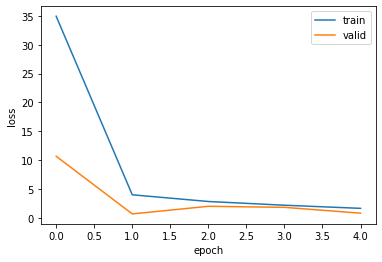

In [ ]:
# 정확도 관련 그래프
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.show()

In [ ]:
rnn_model = models.load_model('best-embedding-model2.h5')   
# 위 학습 중 가장 학습이 좋았던 모델을 로드
# 향후 분류시 위 코드를 통으로 돌리는 것이 아니라
# 위 파일을 다운받아 예측 가능
rnn_model.evaluate(test_seq,y_test)    
# train_test_split 에서 나눠준 test데이터 예측 
# 데이터가 대충 이렇게 예측한다는 것 확인하기 위한 코드
# train_test_split과정 굳이 안해줘도 무방

94/94 [==============================] - 18s 192ms/step - loss: 1.3336 - acc: 0.5129


[1.3336302042007446, 0.5128633379936218]

In [ ]:
rnn_model.predict(test_seq)

array([[0.50667846],
       [0.50667846],
       [0.50667846],
       ...,
       [0.50667846],
       [0.50667846],
       [0.50667846]], dtype=float32)

# LSTM모델 사용

In [ ]:
# 이전버전 모델
'''
model2 = Sequential()
model2.add(Embedding(vocab_size,128,input_length=2000))
model2.add(LSTM(64,dropout=0.4,return_sequences=True))
model2.add(Flatten())
model2.add(Dense(1,activation='sigmoid'))
'''

# 모델 업그레이드
model2 = Sequential()
model2.add(Embedding(vocab_size,300,input_length=2000,weights=[embedding_matrix],
                    trainable=False))
model2.add(SpatialDropout1D(0.25))
model2.add(Bidirectional(LSTM(32,return_sequences=True)))
model2.add(Flatten())
model2.add(Dense(32,activation='relu'))
model2.add(Dense(1,activation='sigmoid'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2000, 300)         26809200  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 2000, 300)        0         
 lDropout1D)                                                     
                                                                 
 bidirectional (Bidirectiona  (None, 2000, 64)         85248     
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 128000)            0         
                                                                 
 dense_2 (Dense)             (None, 32)                4096032   
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
cp = callbacks.ModelCheckpoint('best-lstm-model2.h5')
es = callbacks.EarlyStopping(patience=3,restore_best_weights=True,verbose=1)
rl = callbacks.ReduceLROnPlateau(patience=2)
opt = optimizers.Adam(learning_rate=0.01)
model2.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])
history2 = model2.fit(train_seq, y_train, epochs=4, batch_size=32,validation_split=0.2, callbacks=[cp,es,rl]) # epoch줄이기 2~4회

Epoch 1/4
300/300 [==============================] - 126s 402ms/step - loss: 0.6795 - acc: 0.6896 - val_loss: 0.3943 - val_acc: 0.8848 - lr: 0.0100
Epoch 2/4
300/300 [==============================] - 119s 395ms/step - loss: 0.2788 - acc: 0.9102 - val_loss: 0.1882 - val_acc: 0.9411 - lr: 0.0100
Epoch 3/4
300/300 [==============================] - 118s 395ms/step - loss: 0.3387 - acc: 0.9317 - val_loss: 0.1641 - val_acc: 0.9499 - lr: 0.0100
Epoch 4/4
300/300 [==============================] - 118s 395ms/step - loss: 0.1505 - acc: 0.9542 - val_loss: 0.1086 - val_acc: 0.9720 - lr: 0.0100


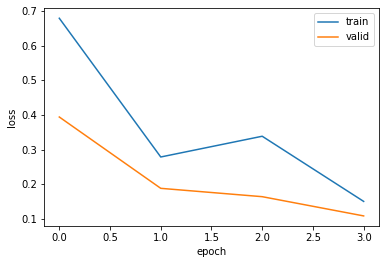

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.show()

In [ ]:
lstm_model = models.load_model('best-lstm-model2.h5')
lstm_model.evaluate(test_seq,y_test)

94/94 [==============================] - 19s 183ms/step - loss: 0.1077 - acc: 0.9679


[0.10768237709999084, 0.9679251313209534]

In [ ]:
lstm_model.predict(test_seq)

array([[9.9999940e-01],
       [9.1474846e-02],
       [3.2654341e-09],
       ...,
       [1.0000000e+00],
       [9.5067191e-01],
       [9.9999988e-01]], dtype=float32)

# GRU 모델 사용

In [ ]:
model3 = Sequential()
model3.add(Embedding(vocab_size,128,input_length=2000))
model3.add(GRU(32,return_sequences=True))
model3.add(Flatten())
model3.add(Dense(1,activation='sigmoid'))
model3.summary()
# GRU 같은 경우는 이전 버전의 층으로 80%정도의 정확도 기록
# 일단 GRU는 이 옵션으로만 적용

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 2000, 128)         11438592  
                                                                 
 gru (GRU)                   (None, 2000, 32)          15552     
                                                                 
 flatten_3 (Flatten)         (None, 64000)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 64001     
                                                                 
Total params: 11,518,145
Trainable params: 11,518,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp = callbacks.ModelCheckpoint('best-gru-model2.h5')
es = callbacks.EarlyStopping(patience=3,restore_best_weights=True,verbose=1)
rl = callbacks.ReduceLROnPlateau(patience=2)
opt = optimizers.Adam(learning_rate=0.01)
model3.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])
history2 = model3.fit(train_seq, y_train, epochs=3, batch_size=32, validation_split = 0.2, callbacks=[cp,es,rl]) # epoch 줄이기 2~4회

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.show()

In [ ]:
gru_model = models.load_model('best-gru-model2.h5')
gru_model.evaluate(test_seq,y_test)

In [ ]:
gru_model.predict(test_seq)

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

# 채점

In [ ]:
test = pd.read_csv('test_data.csv')
test.head()

,html,label
0,"eCash Cards: trusted, automatic Visa cre...",1.0
1,Cash Machine For Everybody - Easy to u...,1.0
2,netAuth You are connected throu...,1.0
3,QF Market - Fast Transfers QF...,1.0
4,[OFFICIAL & ORIGINAL] BITCOIN x200 SERV...,1.0


In [ ]:
input_2 = test['html']

In [ ]:
# 위 train 데이터셋과 동일한 html 전처리
nltk.download('words')
words = set(nltk.corpus.words.words())
processed_html_score = []
for num in range(len(input_2)):
  a = input_2[num]
  sent = re.sub(r'(\dBTC)',' BTC ',a)
  sent_2 = re.sub('[^a-zA-Z0-9\$.]+', ' ', sent)
  #edit = " ".join(w for w in nltk.wordpunct_tokenize(sent) \
  #        if w.lower() in words or not w.isalpha())  
  processed_html_score.append(sent_2)  
len(processed_html_score)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


1726

In [ ]:
# html 전처리2
result_2 = []   
for num in range(len(input_2)):
  word_tokens = text_to_word_sequence(processed_html_score[num],filters='!"#%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')   
  each_list_2 = []           
  for w in word_tokens:
    if w not in stop_words:    
      each_list_2.append(w)
  result_2.append(each_list_2)     
print(result_2)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
tokenizer = Tokenizer(num_words=89364)     
tokenizer.fit_on_texts(result_2)
sequences_2 = tokenizer.texts_to_sequences(result_2)  
print(sequences_2[:5])

[[9438, 2, 591, 830, 89, 48, 5, 490, 15, 58, 37, 313, 9438, 2, 538, 156, 286, 3259, 708, 4841, 274, 2, 15, 58, 37, 445, 365, 1541, 958, 15, 239, 1395, 239, 10328, 4505, 743, 40, 1, 1087, 239, 165, 22, 585, 19, 15, 2, 750, 5, 6692, 172, 63, 498, 180, 2, 1566, 146, 1209, 118, 809, 392, 2543, 268, 119, 30870, 268, 45, 1218, 19, 2, 58, 37, 76, 1554, 8, 308, 734, 392, 297, 20589, 34, 77, 135, 1438, 62, 8, 165, 22, 585, 19, 58, 37, 156, 4], [30, 901, 2215, 203, 29, 15, 22, 1367, 18, 402, 48, 2, 30, 901, 2215, 88, 1688, 7, 13, 747, 574, 91, 67, 86, 270, 287, 426, 429, 123, 1410, 69, 169, 10, 165, 177, 22, 2034, 1075, 67, 51, 2128, 1131, 194, 22, 48, 5, 470, 22, 1673, 128, 287, 1555, 413, 289, 289, 956, 133, 203, 30, 366, 241, 696, 79, 62, 116, 131, 293, 265, 15, 22, 252, 177, 4170, 11534, 1, 15, 22, 252, 177, 4171, 20590, 1, 15, 22, 252, 177, 4172, 6215, 1, 15, 22, 252, 177, 4173, 20591, 1, 15, 22, 252, 177, 4174, 20592, 1, 15, 22, 252, 177, 4175, 20593, 1, 1651, 22, 252, 177, 4176, 6215, 1, 

In [ ]:
word_to_index = tokenizer.word_index  
word_to_index

In [ ]:
max_len = 2000   # 4000 --> 2000
score_seq = pad_sequences(sequences_2,maxlen=max_len)
score_test = score['label']

In [ ]:
# 앞서 만든 rnn_model 로 예측
rnn_model.evaluate(score_seq,score_test)

54/54 [==============================] - 12s 222ms/step - loss: 0.6879 - acc: 0.7990


[0.6879052519798279, 0.798957109451294]

In [ ]:
res = rnn_model.predict(score_seq)
res

array([[0.5044161],
       [0.5044161],
       [0.5044161],
       ...,
       [0.5044161],
       [0.5044161],
       [0.5044161]], dtype=float32)

In [ ]:
df_res = pd.DataFrame(res)
df_res.to_csv('rnn_check.csv',index=False)

In [ ]:
# lstm_model 로 예측
lstm_model.evaluate(score_seq,score_test)

54/54 [==============================] - 9s 152ms/step - loss: 0.5622 - acc: 0.8244


[0.5621842741966248, 0.8244495987892151]

In [ ]:
res = lstm_model.predict(score_seq)
res

array([[0.9506719 ],
       [0.9506719 ],
       [0.8629072 ],
       ...,
       [0.9506719 ],
       [0.9506719 ],
       [0.97697973]], dtype=float32)

In [ ]:
df_res = pd.DataFrame(res)
df_res.to_csv('lstm_check.csv',index=False)

In [ ]:
# gru_model 로 예측
gru_model.evaluate(score_seq,score_test)

54/54 [==============================] - 10s 177ms/step - loss: 9.0041 - acc: 0.8053


[9.004050254821777, 0.805330216884613]

In [ ]:
res = gru_model.predict(score_seq)
res

array([[1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       ...,
       [9.8726237e-01],
       [1.0000000e+00],
       [1.6889901e-32]], dtype=float32)

In [ ]:
df_res = pd.DataFrame(res)
df_res.to_csv('gru_check.csv',index=False)

# 결론
* RNN 정확도: 약 80% 
  * 전부 동일한 확률(51.4%, 1)로 예측했음 
  * 사실상 의미없으므로 이전버전 코드 유지
* LSTM 정확도: 약 83% 
  * 다양한 확률로 예측했음 
  * 의미있는 결과 
* 학습시간 1회 학습당 평균 50초!
* FastText데이터에 없는 단어들로 구성된 html은 거의 다 틀리는 현상 발생
